In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
print("librosa: %s" % librosa.__version__)
print(tf.test.is_gpu_available())
tf.config.list_physical_devices('GPU')


2023-03-07 18:31:36.284967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 18:31:36.386725: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


tensorflow: 2.11.0
librosa: 0.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


2023-03-07 18:31:38.479390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]

2023-03-07 18:31:38.500708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-07 18:31:38.500739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (elijahpc): /proc/driver/nvidia/version does not exist


In [3]:
# Function that converts the user-created audio to the format that the model 
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [4]:
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
# uploaded_file_name = '/root/ws/ml/videos/rachel-last-night-working-here/scene-audio.mp3'
# uploaded_file_name = '/tmp/audiod00c40c5e11de3ecc94e6d0cf47421154a61042d-0-100.wav'
# uploaded_file_name = '/tmp/audiod366c9163dd942266b4bc2553d6852f7993e6162-0-100.wav'
uploaded_file_name = '/tmp/audioc28845dd1fae4617f7395509b5a4dfcfb694f2b2-0-100.wav'
converted_audio_file = convert_audio_for_model(uploaded_file_name)
converted_audio_file

'converted_audio_file.wav'

In [5]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 5.22s
Size of the input: 83520


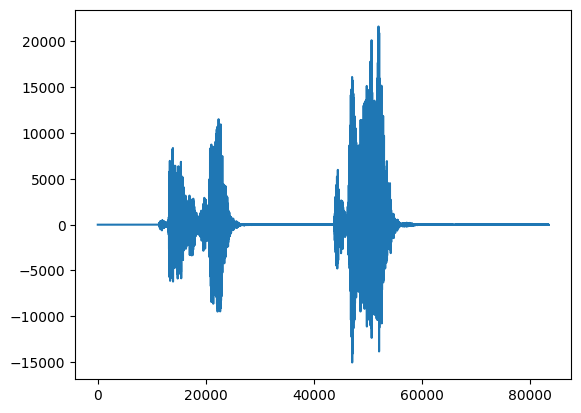

In [6]:
_ = plt.plot(audio_samples)

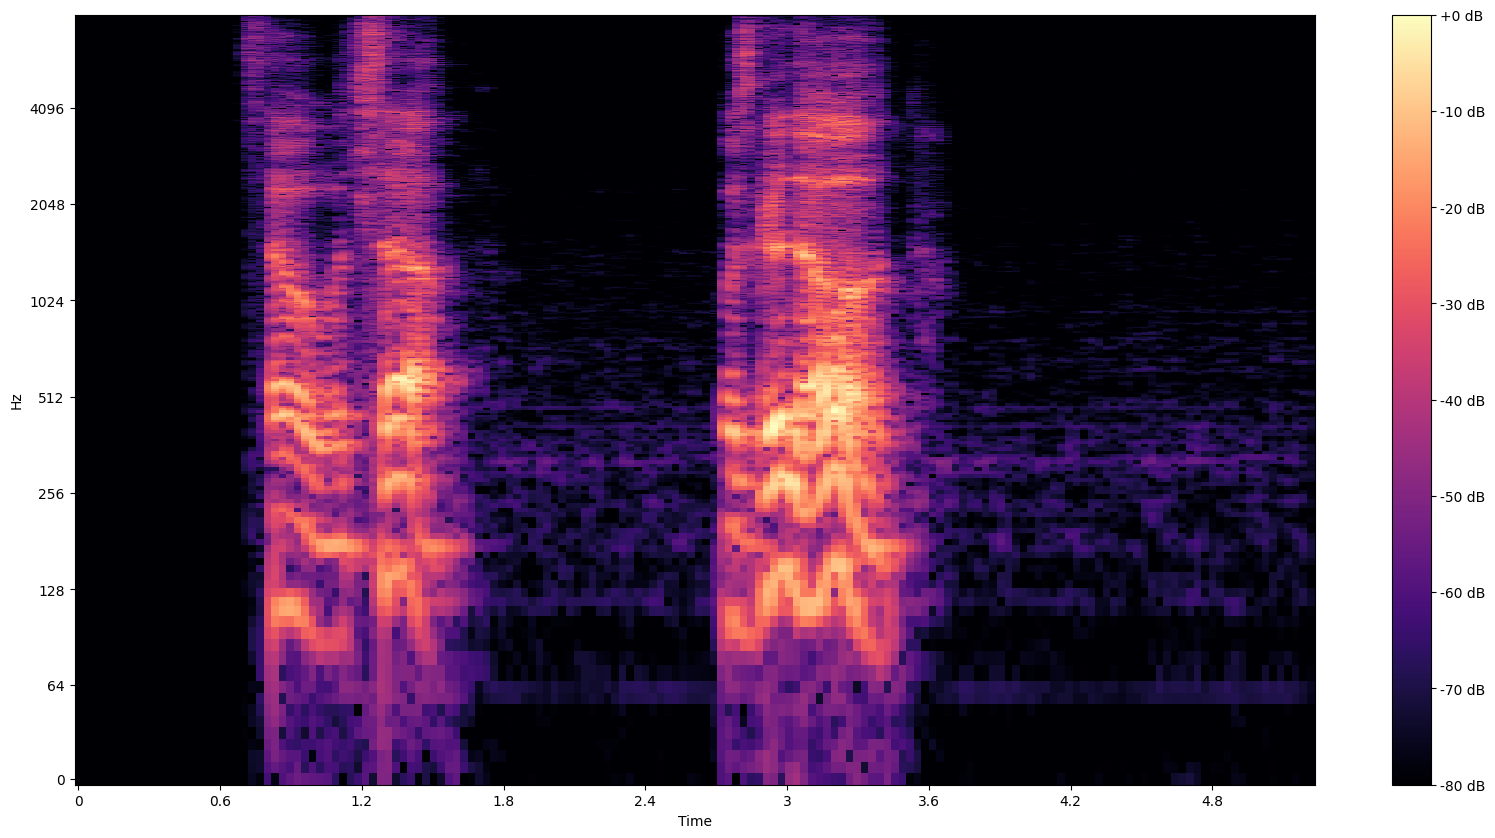

In [7]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log', 
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', x_axis='time', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()

audio_samples = audio_samples / float(MAX_ABS_INT16)

In [8]:
# Loading the SPICE model is easy:
model = hub.load("https://tfhub.dev/google/spice/2")

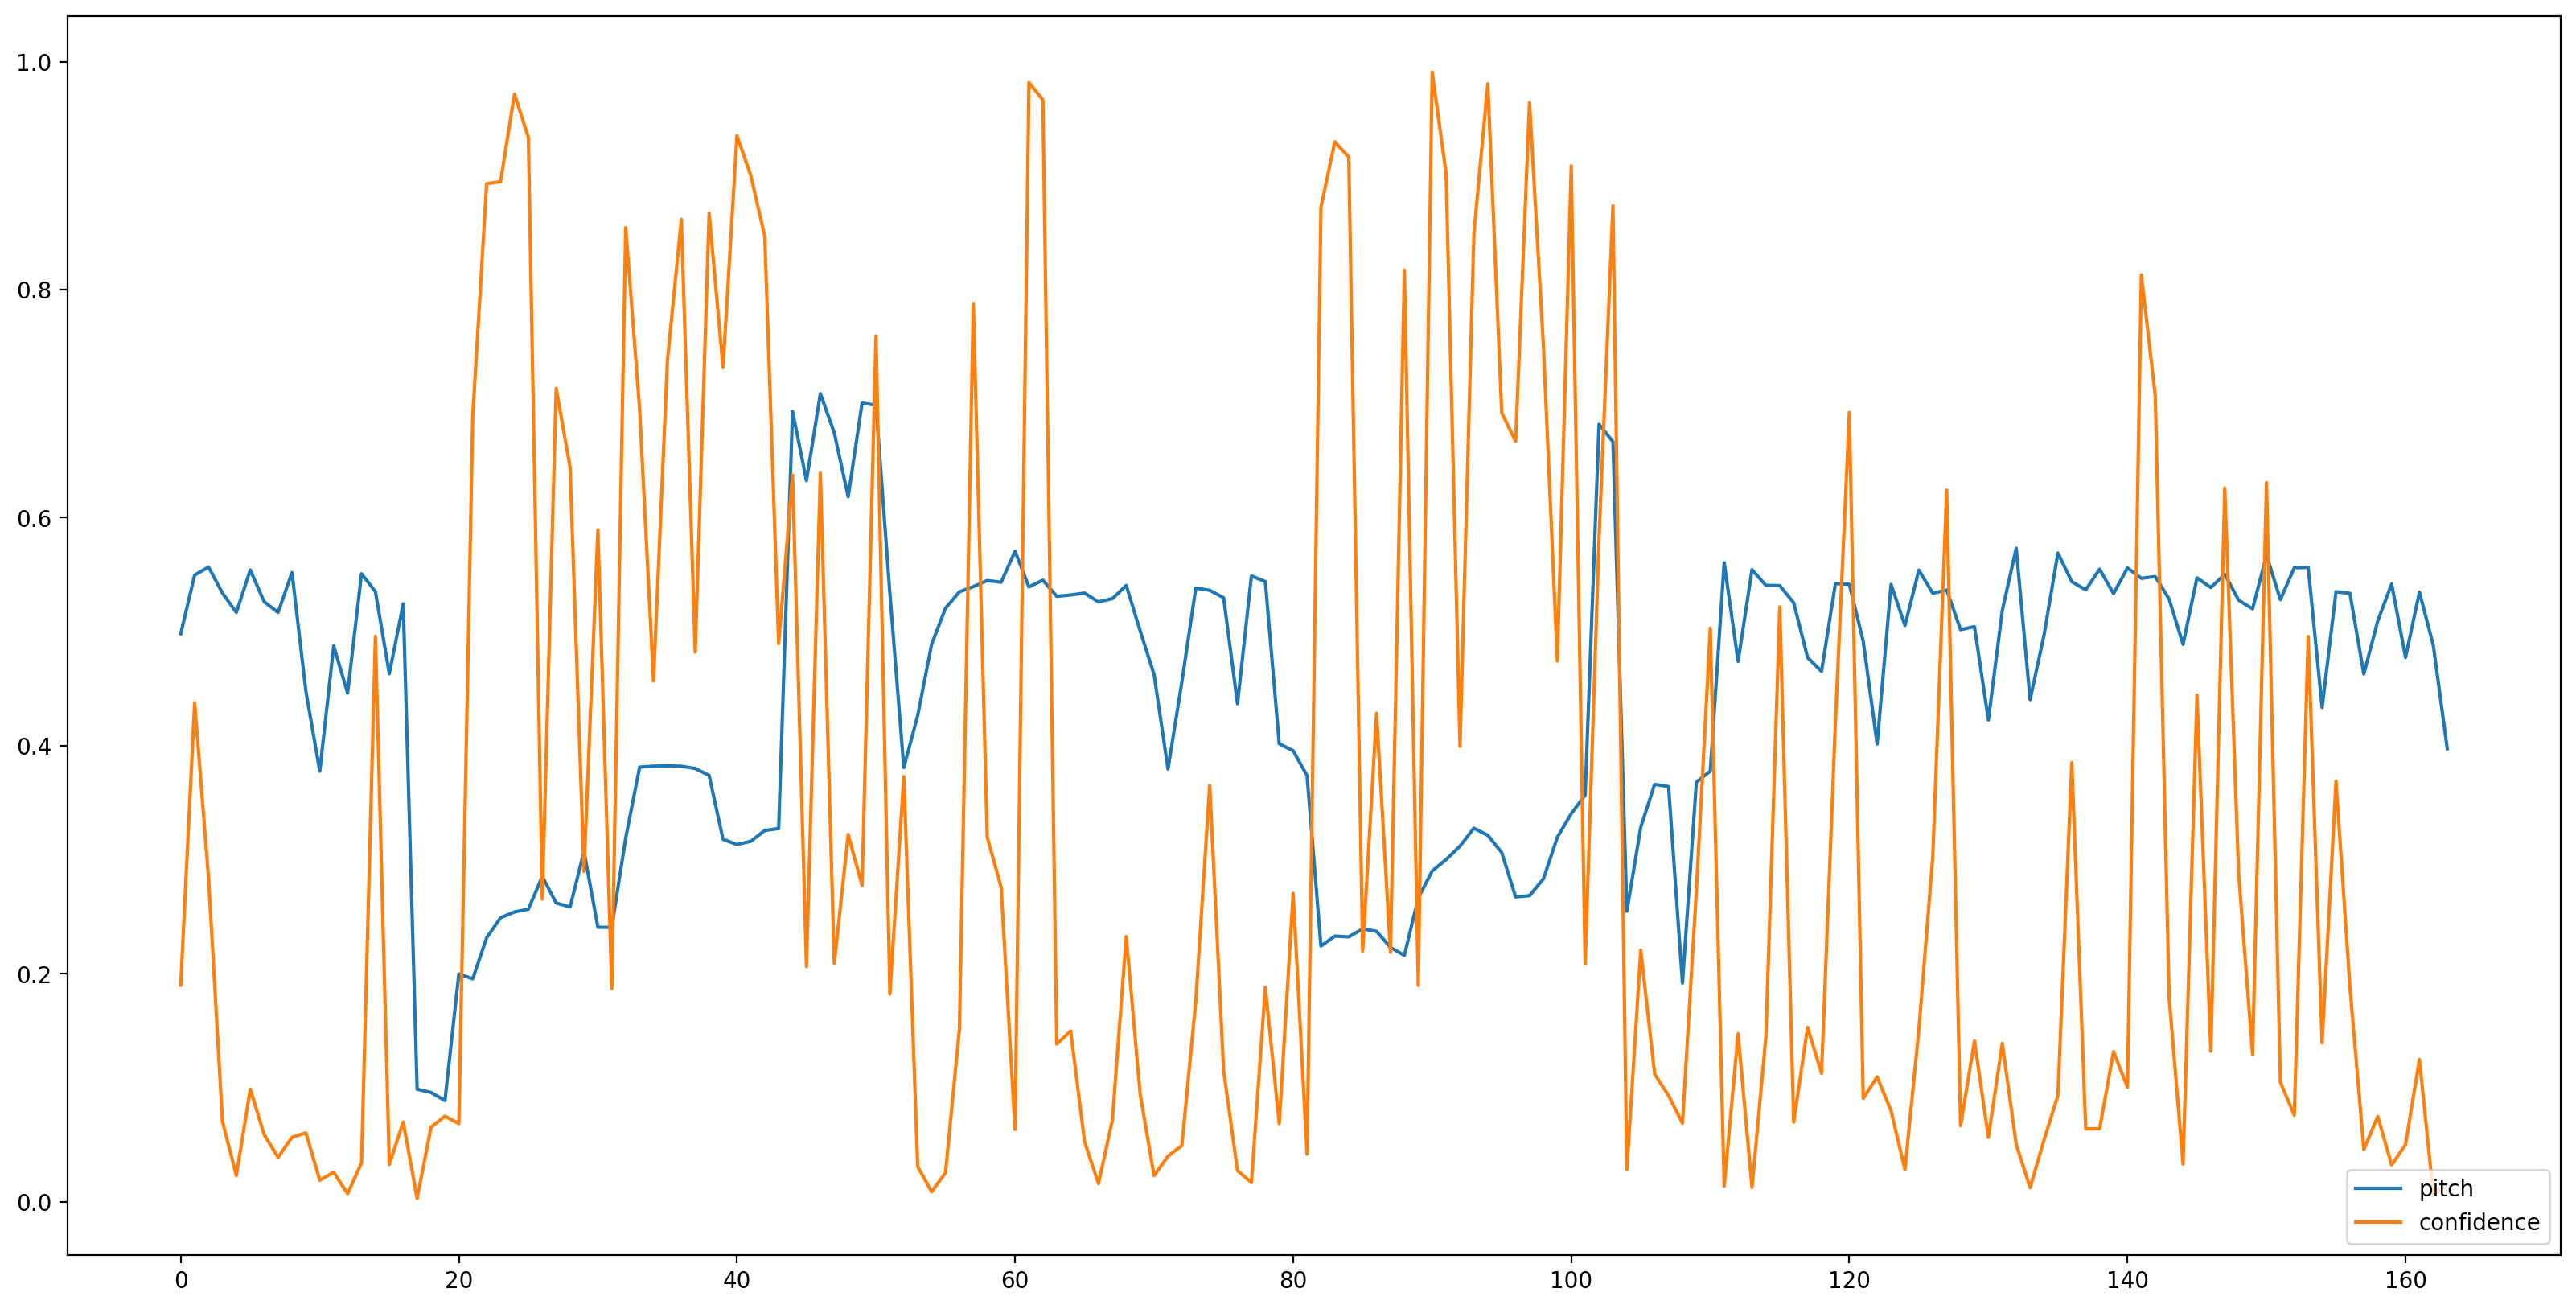

In [9]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
# print(pitch_outputs)
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

In [10]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
print(indices)
confident_pitch_outputs = [ (i,p)
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.75  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
print(confident_pitch_outputs_x)

print(model)

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 10)
# ax.set_ylim([0, 1])
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

# plt.show()

range(0, 164)
(22, 23, 24, 25, 32, 36, 38, 40, 41, 42, 50, 57, 61, 62, 82, 83, 84, 88, 90, 91, 93, 94, 97, 98, 100, 103, 141)


(22, 23, 24, 25, 32, 36, 38, 40, 41, 42, 50, 57, 61, 62, 82, 83, 84, 88, 90, 91, 93, 94, 97, 98, 100, 103, 141)
0.03193548387096774
510.9677419354839
0.03125
[0.6875, 0.71875, 0.75, 0.78125, 1.0, 1.125, 1.1875, 1.25, 1.28125, 1.3125, 1.5625, 1.78125, 1.90625, 1.9375, 2.5625, 2.59375, 2.625, 2.75, 2.8125, 2.84375, 2.90625, 2.9375, 3.03125, 3.0625, 3.125, 3.21875, 4.40625]
[{'time': 0.6875, 'pitch': 0.23148468136787415}, {'time': 0.71875, 'pitch': 0.24901191890239716}, {'time': 0.75, 'pitch': 0.254109263420105}, {'time': 0.78125, 'pitch': 0.25654149055480957}, {'time': 1.0, 'pitch': 0.3189573287963867}, {'time': 1.125, 'pitch': 0.38188549876213074}, {'time': 1.1875, 'pitch': 0.3739033639431}, {'time': 1.25, 'pitch': 0.31328293681144714}, {'time': 1.28125, 'pitch': 0.31609922647476196}, {'time': 1.3125, 'pitch': 0.32557687163352966}, {'time': 1.5625, 'pitch': 0.6987392902374268}, {'time': 1.78125, 'pitch': 0.5394497513771057}, {'time': 1.90625, 'pitch': 0.5391879081726074}, {'time': 1.937

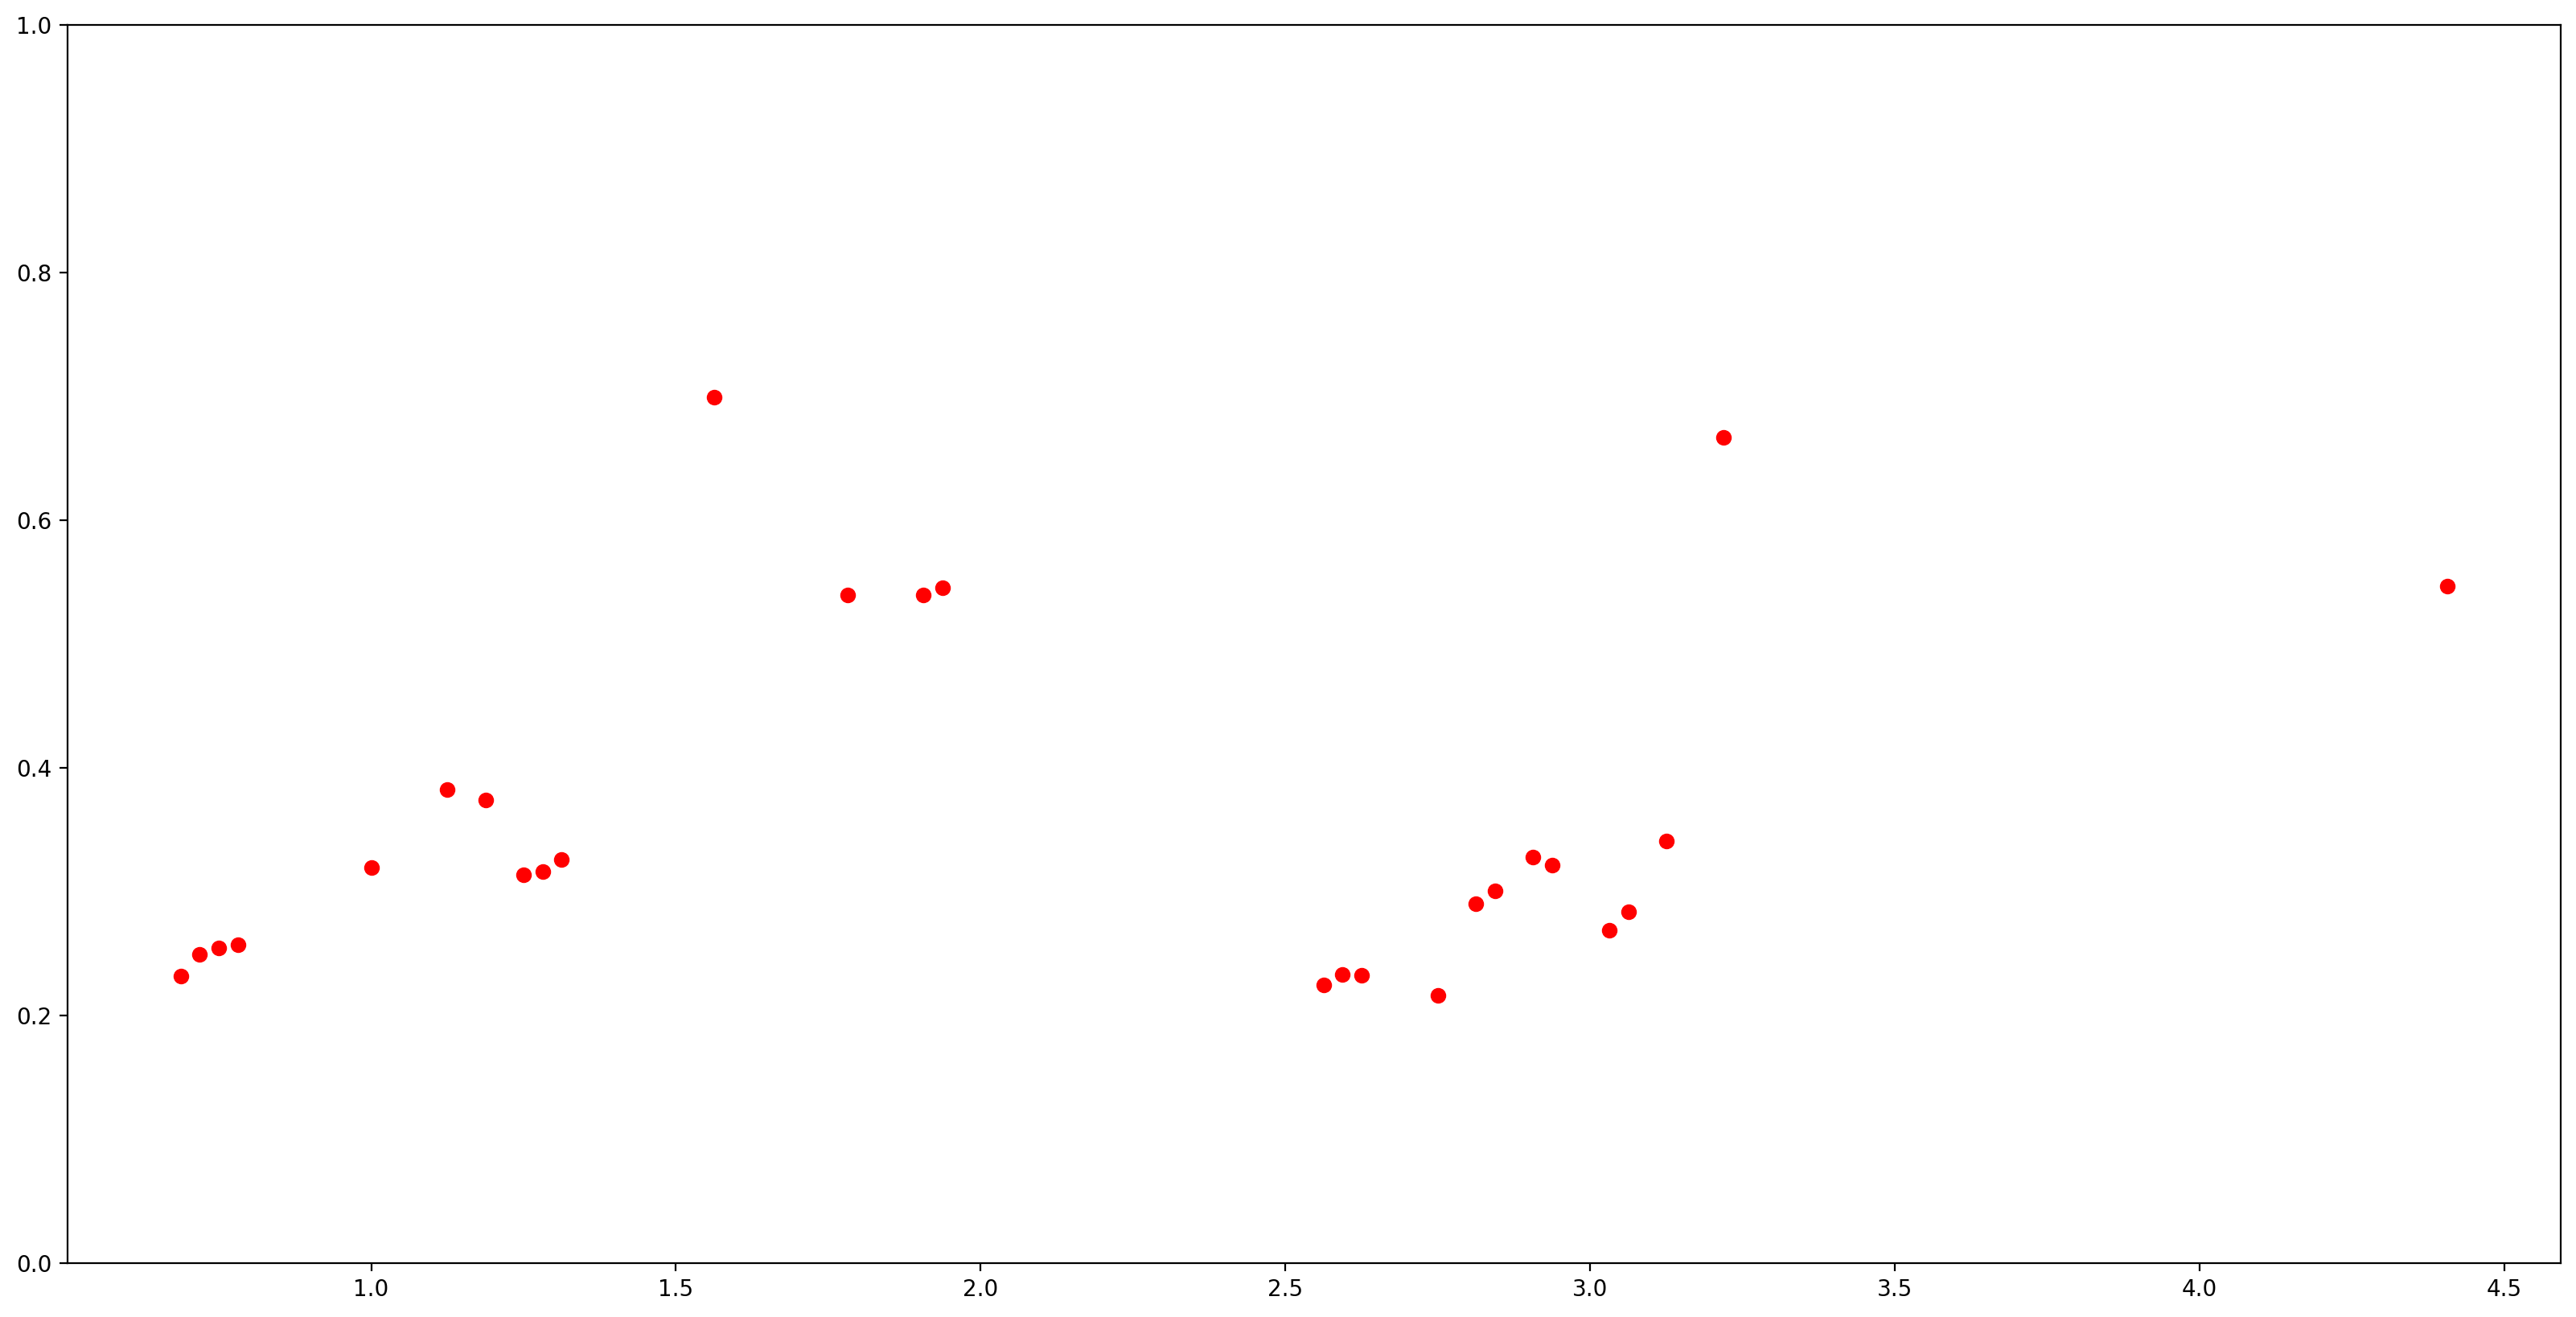

In [11]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.75  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

print(confident_pitch_outputs_x)

# n_fft = 2048

time_offset = 1.98 / 62
print(time_offset)
# time_offset = inputs_to_logits_ratio / 16000
inputs_to_logits_ratio = time_offset * 16000
print(inputs_to_logits_ratio)

inputs_to_logits_ratio = 500
time_offset = inputs_to_logits_ratio / 16000
print(time_offset)

pitch_offsets = [
    {
        # "x": x,
        "time": x * time_offset,
        "pitch": y,
        # "start_time": round(d["start_offset"] * time_offset, 2),
        # "end_time": round(d["end_offset"] * time_offset, 2),
    }
    for x, y in zip(confident_pitch_outputs_x, confident_pitch_outputs_y)
]

confident_pitch_outputs_ts = [ x * time_offset for x in confident_pitch_outputs_x ]
print(confident_pitch_outputs_ts)

plt.scatter(confident_pitch_outputs_ts, confident_pitch_outputs_y, c="r")

print(pitch_offsets)

plt.show()

## Speech recognition

In [12]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch

# load model and processor
speech_processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h")
speech_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import IPython.display as ipd
from datasets import Dataset, interleave_datasets
from datasets import Audio
import numpy as np

# ds = Dataset.from_dict({"audio": ["/root/ws/ml/videos/rachel-last-night-working-here/scene-audio.mp3"]}
speech_ds = Dataset.from_dict({"audio": [converted_audio_file]}).cast_column("audio", Audio(sampling_rate=16_000))
print(speech_ds)
print(speech_ds[0]["audio"])

print(len(speech_ds[0]["audio"]["array"]))

ipd.Audio(data=np.asarray(speech_ds[0]["audio"]["array"]), autoplay=True, rate=16000)

Dataset({
    features: ['audio'],
    num_rows: 1
})
{'path': 'converted_audio_file.wav', 'array': array([0.        , 0.        , 0.        , ..., 0.00030518, 0.00015259,
       0.00012207], dtype=float32), 'sampling_rate': 16000}
83520


In [14]:
print('model: ', speech_model)
print('processor: ', speech_processor)

speech_input_values = speech_processor(
    speech_ds[0]["audio"]["array"], return_tensors="pt", padding="longest").input_values

print(speech_input_values)

# retrieve logits
output = speech_model(speech_input_values)
print('output', output)
speech_logits = output.logits

# take argmax and decode
predicted_ids = torch.argmax(speech_logits, dim=-1)
transcription = speech_processor.batch_decode(predicted_ids, output_word_offsets = True)

print(transcription)

word_offsets = [
    {
        "word": d["word"],
        "start_time": round(d["start_offset"] * time_offset, 2),
        "end_time": round(d["end_offset"] * time_offset, 2),
    }
    for d in transcription.word_offsets[0]
]

word_offsets


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


model:  Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bia

[{'word': 'SO', 'start_time': 1.19, 'end_time': 1.44},
 {'word': "IT'S", 'start_time': 1.75, 'end_time': 1.94},
 {'word': 'THAT', 'start_time': 2.03, 'end_time': 2.38},
 {'word': 'WAS', 'start_time': 4.25, 'end_time': 4.47},
 {'word': 'GOOD', 'start_time': 4.5, 'end_time': 4.72},
 {'word': 'HORD', 'start_time': 4.84, 'end_time': 5.31}]

## Phoneme recognition

In [15]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch

# load model and processor
phoneme_processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-lv-60-espeak-cv-ft")
phoneme_model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-lv-60-espeak-cv-ft")


In [16]:
import IPython.display as ipd
from datasets import Dataset, interleave_datasets
from datasets import Audio
import numpy as np

# ds = Dataset.from_dict({"audio": ["/root/ws/ml/videos/rachel-last-night-working-here/scene-audio.mp3"]}
phoneme_ds = Dataset.from_dict({"audio": [converted_audio_file]}).cast_column("audio", Audio(sampling_rate=16_000))
print(phoneme_ds)
print(phoneme_ds[0]["audio"])

print(len(phoneme_ds[0]["audio"]["array"]))

ipd.Audio(data=np.asarray(phoneme_ds[0]["audio"]["array"]), autoplay=True, rate=16000)


Dataset({
    features: ['audio'],
    num_rows: 1
})
{'path': 'converted_audio_file.wav', 'array': array([0.        , 0.        , 0.        , ..., 0.00030518, 0.00015259,
       0.00012207], dtype=float32), 'sampling_rate': 16000}
83520


In [17]:
# tokenize
input_values = phoneme_processor(
    phoneme_ds[0]["audio"]["array"], return_tensors="pt").input_values
print('input_values', input_values)

print(phoneme_ds[0]["audio"])

# retrieve logits
with torch.no_grad():
    phoneme_logits = phoneme_model(input_values).logits

# model(input_values)

# take argmax and decode
predicted_ids = torch.argmax(phoneme_logits, dim=-1)
# print(predicted_ids)
# transcription = processor.batch_decode(predicted_ids, output_char_offsets = True)
transcription = phoneme_processor.batch_decode(predicted_ids, output_char_offsets = True)
# => should give ['m ɪ s t ɚ k w ɪ l t ɚ ɹ ɪ z ð ɪ ɐ p ɑː s əl ʌ v ð ə m ɪ d əl k l æ s ᵻ z æ n d w iː ɑːɹ ɡ l æ d t ə w ɛ l k ə m h ɪ z ɡ ɑː s p əl']
# print(transcription)

time_offset = phoneme_model.config.inputs_to_logits_ratio / 16000
print(phoneme_model.config.inputs_to_logits_ratio)
# print(time_offset)
# print(transcription.char_offsets)

char_offsets = [
    {
        "char": d["char"],
        "start_time": round(d["start_offset"] * time_offset, 2),
        "end_time": round(d["end_offset"] * time_offset, 2),
    }
    for d in transcription.char_offsets[0]
]

print(char_offsets)
# print(confident_pitch_outputs_ts)

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


input_values tensor([[0.0003, 0.0003, 0.0003,  ..., 0.0059, 0.0031, 0.0025]])
{'path': 'converted_audio_file.wav', 'array': array([0.        , 0.        , 0.        , ..., 0.00030518, 0.00015259,
       0.00012207], dtype=float32), 'sampling_rate': 16000}
320
[{'char': 's', 'start_time': 0.72, 'end_time': 0.74}, {'char': 'a', 'start_time': 0.82, 'end_time': 0.84}, {'char': 'v', 'start_time': 1.02, 'end_time': 1.04}, {'char': 'o', 'start_time': 1.06, 'end_time': 1.08}, {'char': 't', 'start_time': 1.16, 'end_time': 1.18}, {'char': 's', 'start_time': 1.22, 'end_time': 1.24}, {'char': 'a', 'start_time': 1.32, 'end_time': 1.34}, {'char': 'v', 'start_time': 2.72, 'end_time': 2.74}, {'char': 'a', 'start_time': 2.74, 'end_time': 2.76}, {'char': 'z', 'start_time': 2.82, 'end_time': 2.84}, {'char': 'ɡ', 'start_time': 2.88, 'end_time': 2.9}, {'char': 'øː', 'start_time': 2.92, 'end_time': 2.94}, {'char': 'n', 'start_time': 3.02, 'end_time': 3.04}, {'char': 'a', 'start_time': 3.06, 'end_time': 3.08

: 

[{'char': 's', 'start_time': 0.72, 'end_time': 0.74, 'start_pitch': 0.24921581268310547, 'end_pitch': 0.25247811317443847}, {'char': 'a', 'start_time': 0.82, 'end_time': 0.84, 'start_pitch': 0.2675980104718889, 'end_pitch': 0.2733046013968331}, {'char': 'v', 'start_time': 1.02, 'end_time': 1.04, 'start_pitch': 0.32902583599090574, 'end_pitch': 0.33909434318542486}, {'char': 'o', 'start_time': 1.06, 'end_time': 1.08, 'start_pitch': 0.3491628503799439, 'end_pitch': 0.3592313575744629}, {'char': 't', 'start_time': 1.16, 'end_time': 1.18, 'start_pitch': 0.3774155032634735, 'end_pitch': 0.3748612201213837}, {'char': 's', 'start_time': 1.22, 'end_time': 1.24, 'start_pitch': 0.3423807418346405, 'end_pitch': 0.3229822051525115}, {'char': 'a', 'start_time': 1.32, 'end_time': 1.34, 'start_pitch': 0.3367717441916467, 'end_pitch': 0.3666247376799583}, {'char': 'v', 'start_time': 2.72, 'end_time': 2.74, 'start_pitch': 0.21993079781532288, 'end_pitch': 0.21733489632606506}, {'char': 'a', 'start_time

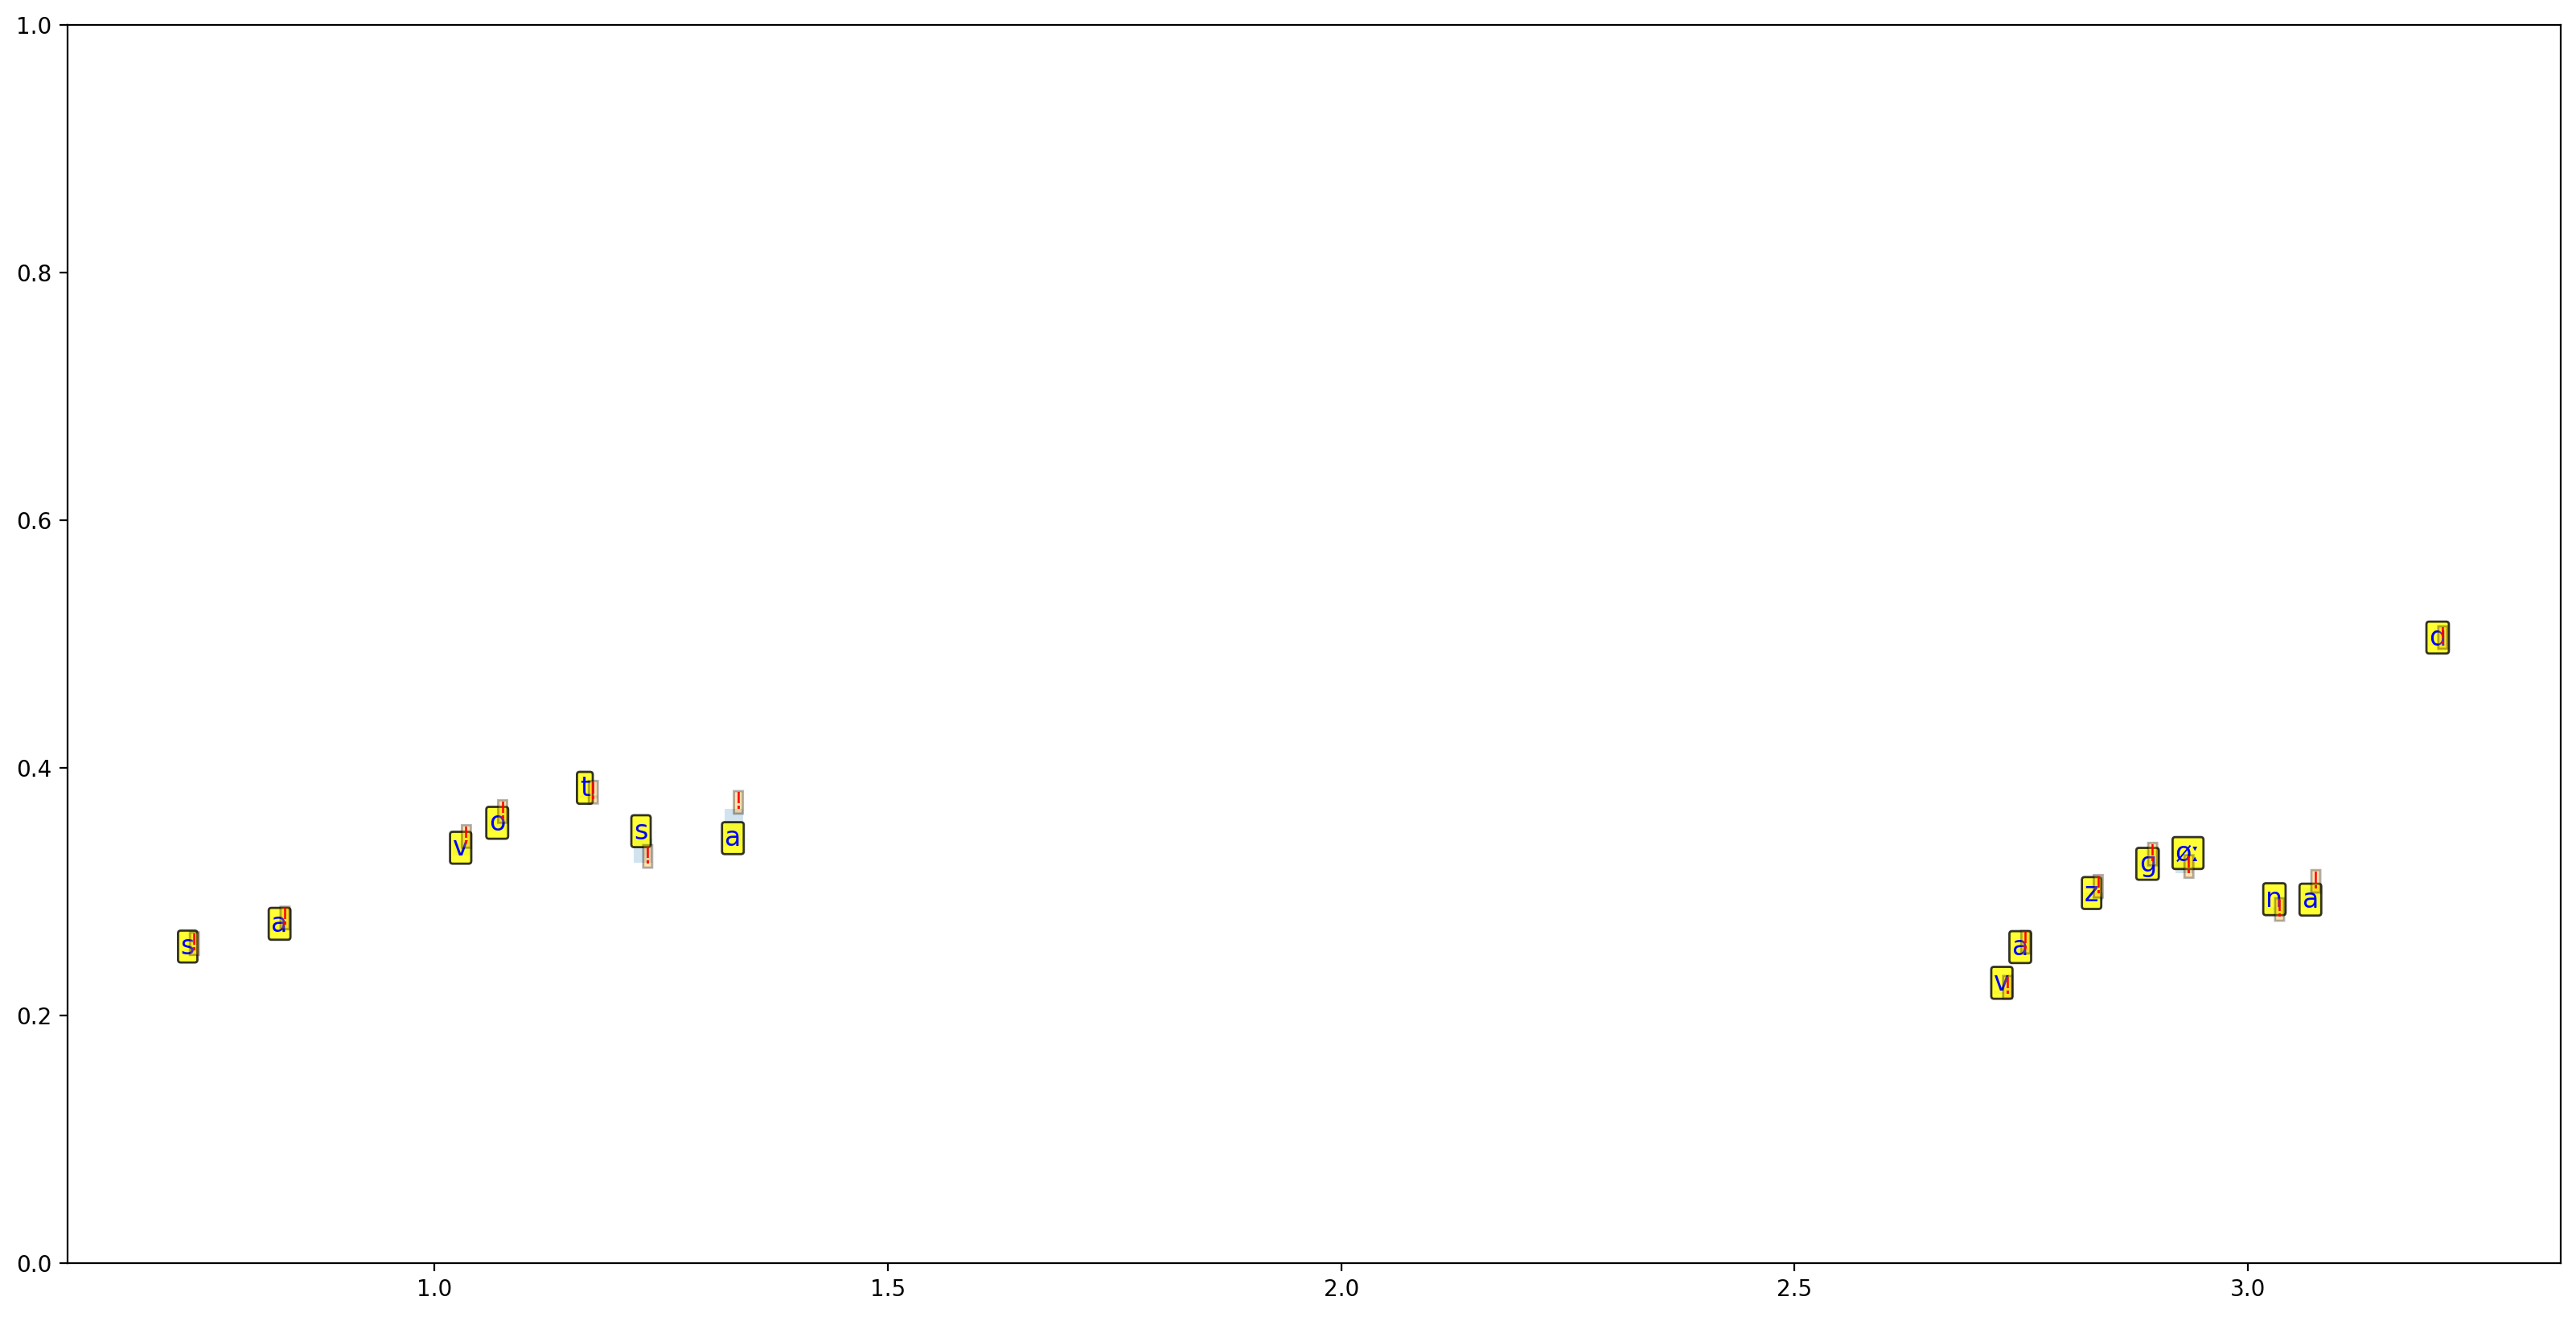

In [18]:
import matplotlib.offsetbox as offsetbox
from scipy import stats
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])

all_offsets = []
for c in char_offsets:
    # print(c)

    start_time = c["start_time"]
    end_time = c["end_time"]

    left_time = None
    middle_times = []
    right_time = None

    first = True
    for o in pitch_offsets:
        if first:
            if pitch_offsets[0]["time"] < start_time:
                left_time = pitch_offsets[0]
            first = False
            continue
        if o["time"] >= start_time:
            break
        if o["time"] < start_time:
            left_time = o

    for o in pitch_offsets:
        if o["time"] > end_time:
            right_time = o
            break

    for o in pitch_offsets:
        if o["time"] >= start_time and o["time"] < end_time:
            middle_times.append(o)
            break

    # print("left_time:", left_time)
    # print("middle_times:", middle_times)
    # print("right_time:", right_time)

    if left_time is None:
        if middle_times[0] is not None:
            left_time = middle_times[0]
            left_time["time"] = start_time
        else:
            left_time = right_time
            left_time["time"] = end_time

    if right_time is None:
        if middle_times[-1] is not None:
            right_time = middle_times[-1]
            right_time["time"] = end_time
        else:
            right_time = left_time
            right_time["time"] = start_time

    time_linregress = []
    pitch_linregress = []
    if left_time is not None:
        time_linregress.append(left_time["time"])
        pitch_linregress.append(left_time["pitch"])
    time_linregress.extend([o["time"] for o in middle_times])
    pitch_linregress.extend([o["pitch"] for o in middle_times])
    if right_time is not None:
        time_linregress.append(right_time["time"])
        pitch_linregress.append(right_time["pitch"])

    # print("time_linregress:", time_linregress)
    # print("pitch_linregress:", pitch_linregress)

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        time_linregress, pitch_linregress)

    start_pitch = slope * start_time + intercept
    end_pitch = slope * end_time + intercept
    # print("start_pitch:", start_pitch)
    # print("end_pitch:", end_pitch)

    all_offsets.append({
        "char": c["char"],
        "start_time": start_time,
        "end_time": end_time,
        "start_pitch": start_pitch,
        "end_pitch": end_pitch,
    })

    plt.axvspan(xmin=start_time, xmax=end_time, ymin=start_pitch, ymax=end_pitch, alpha=0.2)

print(all_offsets)

for c in all_offsets:
    # middle_time = (c["start_time"] + c["end_time"]) / 2
    # time_period = c["end_time"] - c["start_time"]
    # print(time_period)
    plt.text(x=c["start_time"], y=c["start_pitch"], s=c["char"],
             horizontalalignment='left',
             fontdict=dict(color="blue", size=12),
             bbox=dict(facecolor="yellow", alpha=0.8,
                       boxstyle='round,pad=0.1')
             )
    plt.text(x=c["end_time"], y=c["end_pitch"], s="!",
             horizontalalignment='right',
             fontdict=dict(color="red", size=10),
             bbox=dict(facecolor="orange", alpha=0.3,
                       boxstyle='round,pad=0.0')
             )
    # ax.annotate('', xy=(c["start_time"], c["start_pitch"]), xytext=(c["end_time"], c["end_pitch"]),
    #             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=5, width=1, headlength=5))


print(word_offsets)

for w in word_offsets:
    plt.text(x=w["start_time"], y=0.01, s=w["word"],
             horizontalalignment='left',
             fontdict=dict(color="red", size=10),
             bbox=dict(facecolor="yellow", alpha=0.6,
                       boxstyle='round,pad=0.1')
             )
    plt.text(x=w["end_time"], y=0.01, s="!",
             horizontalalignment='right',
             fontdict=dict(color="blue", size=10),
             bbox=dict(facecolor="orange", alpha=0.4,
                       boxstyle='round,pad=0.0')
             )


# plt.scatter(confident_pitch_outputs_ts, confident_pitch_outputs_y, c="b")

plt.show()
